In [4]:
# import nbformat
import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform, Exponential
import torch
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure();


<Figure size 640x480 with 0 Axes>

In [5]:
class SIRModel(Model):
    def __init__(self, N, I0):
        super().__init__() 
        self.N = N
        self.I0 = I0
       
        self.prior_mean = 1
        self.prior_std = math.sqrt(5)
        self.likelyhood_std = 5

    def forward(self):
         #INITIALISE VARIABLES
    
        #time variables. 
        t = 0 #total time that has elapsed 
        t1 = 0 #Time of Expovariate with parameter rate of transmission
        t2 = 0 #Time of Expovariate with parameter rate of recoveries
        t3 = 0 #lowest value of t1 or t2 

        #the current S, I, R variables 
        Sn = self.N - self.I0
        In = self.I0
        Rn = 0

        #list of t, S, I, R to output for plot
        t_list = [t]
        S_list = [Sn]
        I_list = [In]
        R_list = [Rn]
        

        beta = pyprob.sample(Normal(self.prior_mean, self.prior_std))
        gamma = pyprob.sample(Normal(self.prior_mean, self.prior_std))
        
        count = 0
        while In > 0 and Sn > 0: #while a person is still infected
            beta = abs(beta)
            gamma = abs(gamma)
            
            rate_of_transmission = (beta * Sn * In) / self.N #rate if the person transmits the infection
            rate_of_recovery = gamma * In #rate if the person recovers from the infection
            
            t1 = pyprob.sample(Exponential(rate_of_transmission))
            t2 = pyprob.sample(Exponential(rate_of_recovery))
            
            t3 = min(t1.item(), t2.item()) #finds out which of the two events (t1, t2) happens first 

            t += t3 #add the event that happens to total time 
            t_list += [t] #add the event time to the times list 

            if t3 == t1: #if transmission happens first, the new state is (S − 1, I + 1, R)
                Sn -= 1
                In += 1

            if t3 == t2: #if recovery happens first, the new state is (S, I − 1, R + 1)
                In -= 1
                Rn += 1

            #Add current values of S,I,R, into a list
            S_list += [Sn]
            I_list += [In]
            R_list += [Rn]
            
            pyprob.observe(Normal(Sn, self.likelyhood_std), name="sus" + str(count))
            pyprob.observe(Normal(In, self.likelyhood_std), name="inf" + str(count))
            pyprob.observe(Normal(Rn, self.likelyhood_std), name="rec" + str(count))
            
            count += 1
        
        return beta, gamma, t1, t2 #output the times, S,I,R list 

In [6]:
sirModel = SIRModel(1000, 10)

In [7]:
def observant_generator(N,I0, beta, gamma):
    #INITIALISE VARIABLES
    
    #time variables. 
    t = 0 #total time that has elapsed 
    t1 = 0 #Time of Expovariate with parameter rate of transmission
    t2 = 0 #Time of Expovariate with parameter rate of recoveries
    t3 = 0 #lowest value of t1 or t2 
    
    #the current S, I, R variables 
    Sn = N - I0
    In = I0
    Rn = 0
    
    #list of t, S, I, R to output for plot
    t_list = [t]
    S_list = [Sn]
    I_list = [In]
    R_list = [Rn]
    
    while In > 0 and Sn > 0: #while a person is still infected
        beta = abs(beta)
        gamma = abs(gamma)
        rate_of_transmission = (beta * Sn * In) / N #rate if the person transmits the infection
        rate_of_recovery = gamma * In #rate if the person recovers from the infection
        
        t1 = random.expovariate(rate_of_transmission) #Exponentially distributed R.V. with rate of transmission
        t2 = random.expovariate(rate_of_recovery) #Exponentially distributed R.V. with rate of recovery
        t3 = min(t1, t2) #finds out which of the two events (t1, t2) happens first 
        
        t += t3 #add the event that happens to total time 
        t_list += [t] #add the event time to the times list 
        
        if t3 == t1: #if transmission happens first, the new state is (S − 1, I + 1, R)
            Sn -= 1
            In += 1
            
        if t3 == t2: #if recovery happens first, the new state is (S, I − 1, R + 1)
            In -= 1
            Rn += 1
            
        #Add current values of S,I,R, into a list
        S_list += [Sn]
        I_list += [In]
        R_list += [Rn]
        
    return t_list, S_list, I_list, R_list #output the times, S,I,R list 

In [8]:
observdic = {}
for x in range(5000):
    b = np.random.normal(3, 0.3)
    g = np.random.normal(2, 0.3)
    T, S, I, R = observant_generator(1000, 10, b, g)
    for y in range(len(S)):
        address = "sus" + str(y)
        if address in observdic:
            s = observdic[address]
            s.append(S[y])
            observdic[address] = s
            i = observdic["inf"+str(y)]
            i.append(I[y])
            observdic["inf"+str(y)] = i
            r = observdic["rec"+str(y)]
            r.append(R[y])
            observdic["rec"+str(y)]
        else:
            observdic[address] = [S[y]]
            observdic["inf"+str(y)] =  [I[y]]
            observdic["rec"+str(y)] =  [R[y]]

print(len(observdic["inf0"]))

5000


In [9]:
posterior = sirModel.posterior_results(
                    num_traces=5000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS, 
                    observe= observdic )

Time spent  | Time remain.| Progress             | Trace     | Accepted|Smp reuse| Traces/sec
0d:00:03:41 | 0d:00:00:00 | #################### | 5000/5000 |  84.76% |  88.18% | 22.60       


In [10]:
print(posterior.sample())

(tensor(0.8165), tensor(2.1075), tensor(1.1955), tensor(0.7809))


In [11]:
posterior_first = posterior.map(lambda v: v[0]) 
print("mean for beta =",posterior_first.mean)
posterior_second = posterior.map(lambda v: v[1])
print("mean for gamma =",posterior_second.mean)
posterior_third = posterior.map(lambda v: v[2])
print("mean for inf_time =",posterior_second.mean)
posterior_fourth = posterior.map(lambda v: v[3]) 
print("mean for heal_time =",posterior_second.mean)

Map, min_index: 0, max_index: 5000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 5000/5000 | 75,148.91       
mean for beta = tensor(0.5220)
Map, min_index: 0, max_index: 5000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 5000/5000 | 72,737.63       
mean for gamma = tensor(3.0640)
Map, min_index: 0, max_index: 5000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 5000/5000 | 61,393.17       
mean for inf_time = tensor(3.0640)
Map, min_index: 0, max_index: 5000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 5000/5000 | 56,917.71       
mean for heal_time = tensor(3.0640)


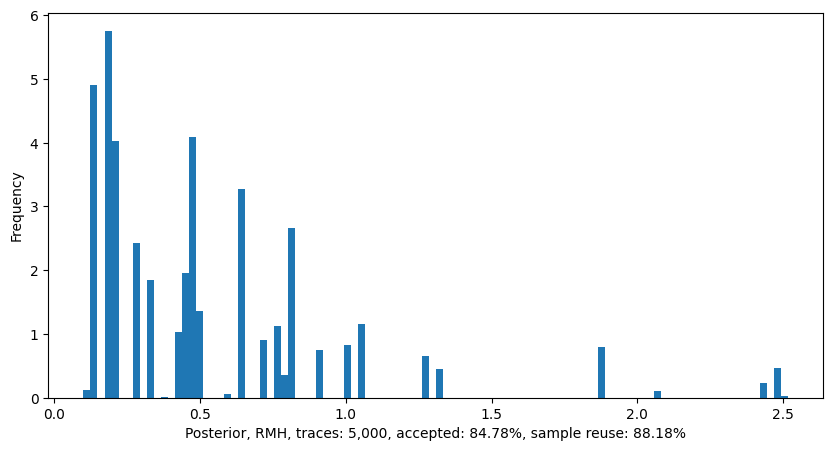

In [12]:
posterior_first.plot_histogram(show=True, bins=100)

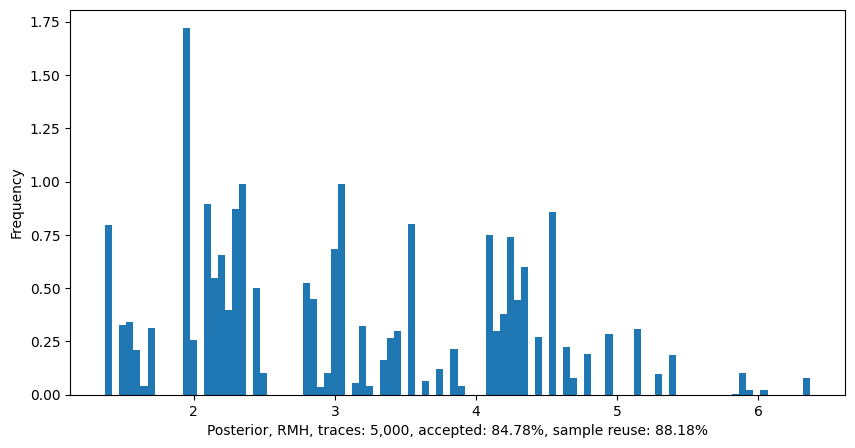

In [13]:
posterior_second.plot_histogram(show=True, bins=100)

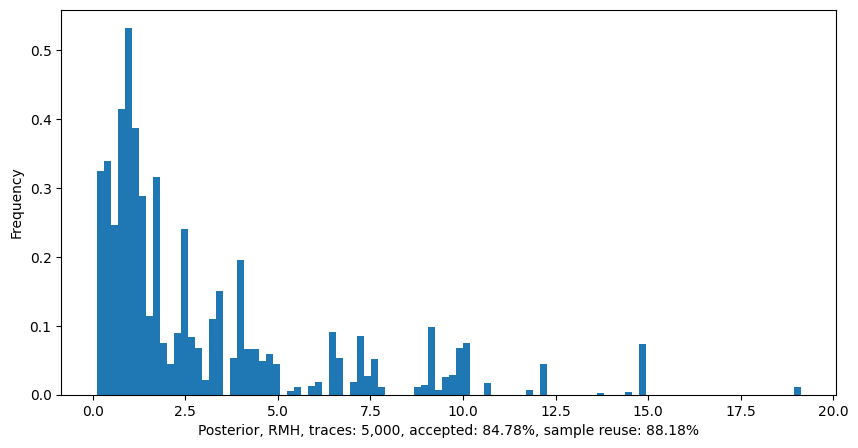

In [14]:
posterior_third.plot_histogram(show=True, bins=100)

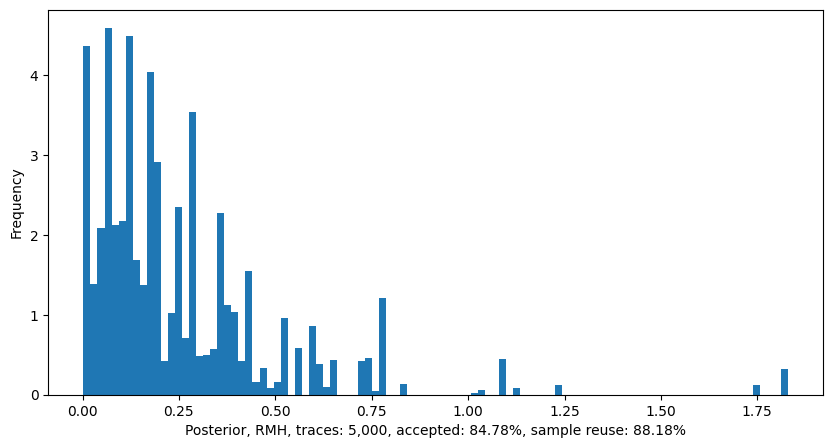

In [15]:
posterior_fourth.plot_histogram(show=True, bins=100)

Below is the inference compilation

In [6]:
observemb = {}

for i in range(74):
    observemb["sus"+str(i)] = {'dim' : 32}
    observemb["inf"+str(i)] = {'dim' : 32}
    observemb["rec"+str(i)] = {'dim' : 32}

In [7]:
sirModel.learn_inference_network(num_traces=20000,
            observe_embeddings=observemb,
            inference_network=pyprob.InferenceNetwork.LSTM)

Creating new inference network...
Observable sus0: reshape not specified, using shape torch.Size([]).
Observable sus0: using embedding dim torch.Size([32]).
Observable sus0: observe embedding not specified, using the default FEEDFORWARD.
Observable sus0: embedding depth not specified, using the default 2.
Observable inf0: reshape not specified, using shape torch.Size([]).
Observable inf0: using embedding dim torch.Size([32]).
Observable inf0: observe embedding not specified, using the default FEEDFORWARD.
Observable inf0: embedding depth not specified, using the default 2.
Observable rec0: reshape not specified, using shape torch.Size([]).
Observable rec0: using embedding dim torch.Size([32]).
Observable rec0: observe embedding not specified, using the default FEEDFORWARD.
Observable rec0: embedding depth not specified, using the default 2.
Observable sus1: reshape not specified, using shape torch.Size([]).
Observable sus1: using embedding dim torch.Size([32]).
Observable sus1: observe

RuntimeError: Distribution currently unsupported: Exponential

In [ ]:
inference_posterior = sirModel.posterior_results(
                num_traces=10000, # the number of samples estimating the posterior
                inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, 
                observe= observdic )

In [ ]:
inf_posterior_first = posterior.map(lambda v: v[0]) 
print("mean for beta =",posterior_first.mean)
inf_posterior_second = posterior.map(lambda v: v[1])
print("mean for gamma =",posterior_second.mean)
inf_posterior_third = posterior.map(lambda v: v[2])
print("mean for inf_time =",posterior_second.mean)
inf_posterior_fourth = posterior.map(lambda v: v[3]) 
print("mean for heal_time =",posterior_second.mean)

In [ ]:
inf_posterior_first.plot_histogram(show=True, bins=100)

In [ ]:
inf_posterior_second.plot_histogram(show=True, bins=100)

In [ ]:
inf_posterior_third.plot_histogram(show=True, bins=100)

In [ ]:
inf_posterior_fourth.plot_histogram(show=True, bins=100)